# Final Project Code

In [23]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sklearn as skl
from scipy.io import loadmat
import pandas as pd
from sklearn.preprocessing import scale
from sklearn import cross_validation
from sklearn.preprocessing import scale
from sklearn.cross_decomposition import PLSRegression
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split

In [24]:
#Load the data
data = np.loadtxt("breast-cancer-wisconsin.data.csv", delimiter=",")

#change 2 to 0 and 4 to 1
for i in range(len(data)):
    if data[i,10] == 2:
        data[i,10] = 0
    elif data[i,10] == 4:
        data[i,10] = 1
        
X = data[:,1:10]
Y = data[:,10]

# PLS-DA

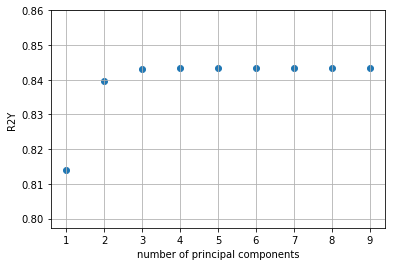

[ 0.81397888  0.83974134  0.84295668  0.84325165  0.84329905  0.84332356
  0.84332412  0.84332413  0.84332413]


In [25]:
#Perform PLS-DA
n = 10
R2Y = np.zeros(n-1)
for i in range(1,n):
    PLS = PLSRegression(n_components = i, max_iter = 1000)
    #now we can call functions on PLS such as "PLS.fit"

    xScores, yScores = PLS.fit_transform(scale(X), scale(Y)) # xSc is not the same as PLS.x_scores_

    R2Y[i-1] = PLS.score(scale(X), scale(Y))

    #Y_predict = PLS.predict(X)
    #R2Y[i-1] = 1 - (np.sum(Y_predict - Y48)**2) / np.sum(Y48)**2

plt.figure()
plt.scatter(np.arange(1,n), R2Y)
plt.xlabel("number of principal components")
plt.ylabel("R2Y")
plt.grid()
plt.show()
print(R2Y)

In [26]:
#Choose 2 components
PLS = PLSRegression(n_components = 2, max_iter = 1000)
xScores1, yScores = PLS.fit_transform(scale(X), scale(Y))
xloadings = PLS.x_loadings_
yloadings = PLS.y_loadings_

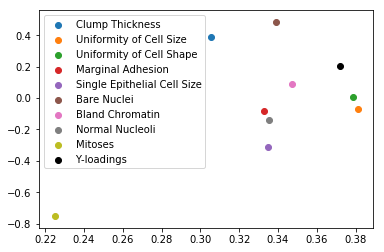

In [27]:
#Overlay X and y Loadings
labels = ['Clump Thickness', 'Uniformity of Cell Size', 'Uniformity of Cell Shape','Marginal Adhesion','Single Epithelial Cell Size','Bare Nuclei','Bland Chromatin','Normal Nucleoli','Mitoses']
for i in range(len(xloadings)):
    plt.scatter(xloadings[i,0], xloadings[i,1], label = labels[i] )

plt.scatter(yloadings[:,0], yloadings[:,1], c = 'k', label = 'Y-loadings')
plt.legend(loc = 2)
plt.show()

In [28]:
#Predict Y
#Y_predicted = PLS.predict(scale(X))

In [29]:
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
yplsda = np.zeros(len(Y))
Xda = scale(X)
Yda = scale(Y)
for train_index, test_index in loo.split(X):
    X_train, X_test = Xda[train_index], Xda[test_index]
    Y_train, Y_test = Yda[train_index], Yda[test_index]
    PLS = PLSRegression(n_components = 2, max_iter = 1000)
    xScores, yScores = PLS.fit_transform(X_train, Y_train)
    yplsda[test_index] = PLS.predict(X_test)

In [30]:
#Create a cutoff for what is classified as 0 vs 1
from sklearn.metrics import confusion_matrix
yplsda_pred = np.zeros(len(Y))
j = -1
for i in yplsda:
    j = j +1
    if i>0:
        yplsda_pred[j] = 1
    else:
        yplsda_pred[j] = 0

confusions_matrix = confusion_matrix(Y, yplsda_pred)
print(confusions_matrix)

[[431  13]
 [  5 234]]


## Logistic Regression

Perform Logistic Regression on the data

In [31]:
from sklearn.model_selection import KFold

y_pred = np.zeros(len(Y))
kf = KFold(n_splits=5)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    logreg = LogisticRegression()
    logreg.fit(X_train, Y_train);
    y_pred[test_index] = logreg.predict(X_test)

In [32]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(Y, y_pred)
print(confusion_matrix)

[[433  11]
 [ 15 224]]


In [33]:
#Perform Leave one out instead of 5-fold CV
lool = LeaveOneOut()
ys = np.zeros(len(Y))
for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    logreg = LogisticRegression()
    logreg.fit(X_train, Y_train);
    ys[test_index] = logreg.predict(X_test)

In [34]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(Y, ys)
print(confusion_matrix)

[[433  11]
 [ 14 225]]


The result from the confusion matrix is telling us that we have 433+224 correct predictions and 15+11 incorrect predictions.

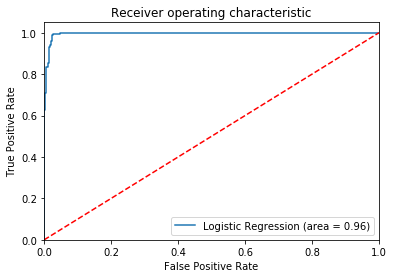

In [35]:
#Receiver operating characteristic: ROC Curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(Y, y_pred)
fpr, tpr, thresholds = roc_curve(Y, logreg.predict_proba(X)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()
